In [1]:
#This is the code that we have written (in progress) to solve Homework 1 of the FRIB Theory TALENT Summer School
#This code will (when we complete it) compute scattering cross sections as a function of E and l via the partial-wave method, using the Numerov integration method to compute the scattering wavefunction
#Authors:  Chad Ummel, Heather Garland, Rajesh Ghimire, Natalia Calleya

import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import special as sp

In [2]:
#Eventual inputs that we will pre-define for now
E = 1 #Lab energy
l = 0

In [3]:
#Physical constants
hbar = 197.3286 #(hbar*c in MeV fm)
mp = 938.272 #Proton mass (in MeV)
mn = 939.565 #Neutron mass (in MeV)
mu = mp*mn/(mp+mn) #Reduced mass
ECM = mn/(mp+mn)*E #CM Energy (assuming proton beam)

In [4]:
#Malfliet-Tjon potential parameters
VA = 626.8932
muA = 1.550
VR = 1438.7228
muR = 3.11

In [5]:
#Numerical Integration parameters
r0 = 1e-5 #Starting point for r (in fm).  Let's start at r=0
h = 0.05 #Step size in fm
nmax = 1000 #Terminate the integration after 1000 steps

In [6]:
%%capture
n = np.linspace(0,nmax+1,nmax+2)
r = r0+n*h
V = VR*np.exp(-muR*r)/r - VA*np.exp(-muA*r)/r
Vang = l*(l+1)*(hbar**2)/(2*mu*(r**2))
Veff = V + Vang
ksq = 2*mu*(ECM - Veff)/(hbar**2)
k = np.sqrt(ksq)
u = [0]*nmax

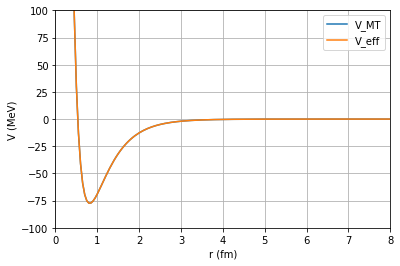

In [7]:
plt.grid(1)
plt.plot(r,V,label="V_MT")
plt.plot(r,Veff,label="V_eff")
plt.ylim(-100,100)
plt.xlim(0,8)
plt.xlabel('r (fm)')
plt.ylabel('V (MeV)')
plt.legend();

In [8]:
#Boundary conditions
u[0] = 0 #u(r=0) = 0
u[1] = h**(l+1) #What is a good choice for this?

In [9]:
#Compute the wavefunction using the Numerov method
for i in range(1,nmax-1,1):
    u[i+1] = (2*(1-5/12*(h**2)*ksq[i])*u[i]-(1+1/12*(h**2)*ksq[i-1])*u[i-1])/(1+1/12*(h**2)*ksq[i+1])

In [10]:
#Compute the phase shift using Carl's pseudo-Wronskian method
n2 = np.linspace(0,nmax-1,nmax)
r2 = r0+n2*h
deltal = np.arctan((u[-2]*sp.jn(l,k[-3]*r2[-1])-u[-1]*sp.jn(l,k[-4]*r2[-2]))/(u[-2]*sp.yn(l,k[-3]*r2[-1])-u[-1]*sp.yn(l,k[-4]*r2[-2])))

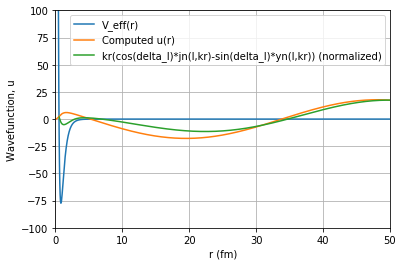

In [11]:
asymptotic=k*r*(math.cos(deltal)*sp.jn(l,k*r)-math.sin(deltal)*sp.yn(l,k*r))
ANC = u[-1]/asymptotic[-3]
plt.plot(r,Veff,label="V_eff(r)")
plt.plot(r2,u,label="Computed u(r)")
plt.plot(r,ANC*asymptotic,label="kr(cos(delta_l)*jn(l,kr)-sin(delta_l)*yn(l,kr)) (normalized)")
plt.xlim(0,r[-1])
plt.ylim(-100,100)
plt.grid(1)
plt.xlabel('r (fm)')
plt.ylabel('Wavefunction, u');
plt.legend();